In [62]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors
dataset_path  = '/opt/ml/segmentation/merge_image'
anns_file_path = dataset_path + '/' + 'labeling_data.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())


In [63]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 21434
Number of images: 2999


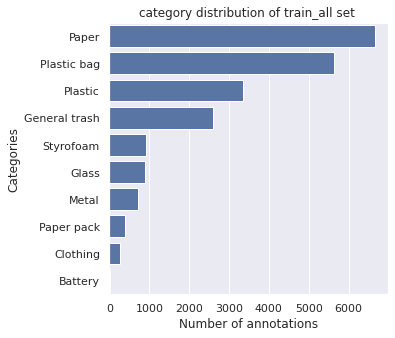

In [64]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [65]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.data_df = pd.json_normalize(dataset['annotations'])
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        # 클래스 글자 넣기
        listbox = list(self.data_df.loc[self.data_df['image_id'] == index]['bbox'])
        listlabel = list(self.data_df.loc[self.data_df['image_id'] == index]['category_id'])
        for i, c in zip(listbox, listlabel):
            xmin, ymin, w, h = i
            xmax = xmin + w
            ymax = ymin + h
            images = cv2.rectangle(images, (xmin, ymin), (xmax, ymax), (0, 0, 0), 3)
            text_size, _ = cv2.getTextSize(str(c), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            text_w, text_h = text_size
            
            if xmin - text_h < 1:
                cv2.rectangle(images, (xmin, ymin), (xmin + text_w, ymin + 15 + text_h), [255,255,255], -1)
                images = cv2.putText(images, str(c), (xmin, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            else:
                cv2.rectangle(images, (xmin, ymin - 15 - text_h), (xmin + text_w, ymin), [255,255,255], -1)
                images = cv2.putText(images, str(c), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [66]:
torch.cuda.empty_cache()
config = {"epochs" : 20,
          "batch_size" : 16,
          "learning_rate" : 0.0001,
          "criterion" : 'CELoss',
          "optimizer" : 'adam',
          "weight_decay" : 1e-6,
          "num_workers" : 2
          }

In [67]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/labeling_data.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])



# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=config['batch_size'],
                                           shuffle=True,
                                           num_workers=config['num_workers'],
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.85s)
creating index...
index created!


In [68]:
for i in train_dataset:
    print(i)
    break

(tensor([[[0.9843, 0.9569, 0.8157,  ..., 0.4392, 0.4196, 0.4353],
         [0.9843, 0.9686, 0.8549,  ..., 0.4118, 0.4314, 0.4392],
         [0.9804, 0.9804, 0.9098,  ..., 0.4431, 0.4196, 0.4275],
         ...,
         [0.5725, 0.5647, 0.5608,  ..., 0.0980, 0.0824, 0.0863],
         [0.5529, 0.5490, 0.5647,  ..., 0.1255, 0.0824, 0.0314],
         [0.5490, 0.5451, 0.5490,  ..., 0.0706, 0.0588, 0.0353]],

        [[1.0000, 0.9765, 0.8510,  ..., 0.4824, 0.4627, 0.4784],
         [1.0000, 0.9882, 0.8902,  ..., 0.4549, 0.4745, 0.4824],
         [1.0000, 1.0000, 0.9451,  ..., 0.4863, 0.4627, 0.4706],
         ...,
         [0.5255, 0.5176, 0.5137,  ..., 0.1608, 0.1490, 0.1608],
         [0.5059, 0.5020, 0.5176,  ..., 0.1882, 0.1490, 0.1059],
         [0.5020, 0.4980, 0.5020,  ..., 0.1333, 0.1255, 0.1098]],

        [[1.0000, 0.9804, 0.8667,  ..., 0.4980, 0.4784, 0.4941],
         [1.0000, 0.9922, 0.9059,  ..., 0.4706, 0.4902, 0.4980],
         [0.9961, 1.0000, 0.9608,  ..., 0.5020, 0.4784, 0

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {1, 'General trash'}, {6, 'Plastic'}]


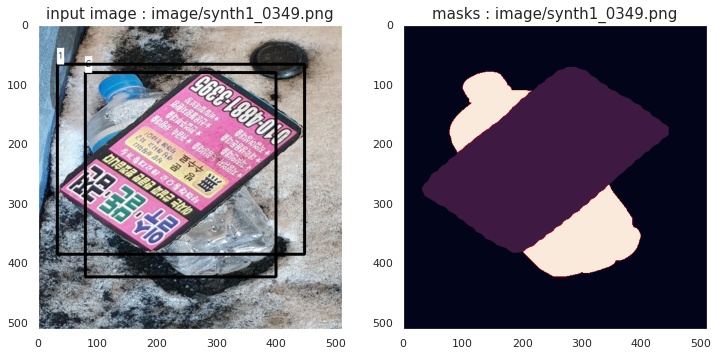

In [80]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks  
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])
ax1.imshow(temp_images[0].permute([1,2,0]))

ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

NameError: name 'test_loader' is not defined

In [14]:
extractImgPath = '/opt/ml/segmentation/extract_image/'

In [15]:

ImgNames = [_.stem for _ in Path(f"/opt/ml/segmentation/merge_image/mask/image").iterdir()]
print(f"cat1ImgNames: {ImgNames.__len__()}")

cat1ImgNames: 3035


In [47]:
### segmentation 잘못 나온거 제거하기
data_df = pd.json_normalize(dataset['annotations'])
image_index = set([])
anno_index = set([])
for i, v in enumerate(dataset['annotations']):
    if len(v['segmentation']) == 0:
        idx = data_df.iloc[i]['image_id']
        image_index.add(int(idx))
        anno_index.update(list(map(int, data_df.loc[data_df['image_id'] == data_df.iloc[i]['image_id']].index)))
anno_index = list(anno_index)
image_index = list(image_index)
anno_index.sort()
image_index.sort()

414

In [53]:
import copy
new_dataset = {}
new_dataset['info'] =  copy.deepcopy(dataset['info'])
new_dataset['licenses'] = copy.deepcopy(dataset['licenses'])
new_dataset['categories'] = copy.deepcopy(dataset['categories'])
new_dataset['annotations'] = []
new_dataset['images'] = []
for i, v in enumerate(dataset['annotations']):
    if i%1000 == 0:
        print(i)
    if i in anno_index:
        continue
    else:
        new_dataset['annotations'].append(copy.deepcopy(v))

for i, v in enumerate(dataset['images']):
    if i%1000 == 0:
        print(i)
    if i in image_index:
        continue
    else:
        new_dataset['images'].append(copy.deepcopy(v))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
0
1000
2000
3000


In [60]:
for i, v in enumerate(new_dataset['annotations']):
    if len(v['segmentation']) == 0:
        print(i)
        break

In [202]:
for i in dataset['images']:
    image = Image.open("/opt/ml/segmentation/merge_image_q/mask/" + i['file_name'])
    image2 =  Image.open("/opt/ml/segmentation/merge_image_q/" + i['file_name'])
    image.save("/opt/ml/segmentation/merge_image/mask/" + i['file_name'])
    image2.save("/opt/ml/segmentation/merge_image/" + i['file_name'])

In [61]:
import json
with open('/opt/ml/segmentation/merge_image/labeling_data.json', 'w', encoding = 'utf-8') as make_file:
    json.dump(new_dataset, make_file, ensure_ascii = False, indent = "\t")

In [1]:
import cv2
import json
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

In [130]:
class_colormap = pd.read_csv("/opt/ml/segmentation/baseline_code/class_dict.csv")
color_map_array = class_colormap.iloc[:, 1:].values.astype(np.uint8)

category_names = ["Backgroud", "General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

coco = COCO('/opt/ml/segmentation/input/train_all/labeling_data.json')

imgIds = coco.getImgIds()

# annImgDir = '/opt/ml/segmentation/input/ann_data'

loading annotations into memory...
Done (t=5.81s)
creating index...
index created!


In [131]:
masks = []
imgNames = []

for imgId in tqdm(imgIds):
    imgInfo = coco.loadImgs(imgId)[0]

    annIds = coco.getAnnIds(imgIds=imgInfo['id'])
    anns = coco.loadAnns(annIds)

    mask = np.zeros((imgInfo["height"], imgInfo["width"]), dtype=np.uint8)

    anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=True)
    for ann in anns:
        annCatId = ann['category_id']
        assert annCatId != 0, 'category_id must be not 0.'
        mask[coco.annToMask(ann) == 1] = annCatId

    if np.any(np.isin([1, 2, 8, 6], mask)):
        imgNames.append(imgInfo['file_name'])
        masks.append(mask)
    
    # mask_list.append(list(np.unique(mask)))
    # mask_list.update(np.unique(mask))
    # _file_name = f"{annImgDir}/{imgInfo['file_name']}"
    # _parent_path = Path(_file_name).parent
    # if not _parent_path.exists():
    #     _parent_path.mkdir(parents=True)

    # # plt.imsave(_file_name, color_map_array[mask]) # rgb
    # plt.imsave(_file_name, mask)
    # plt.imsave('test_mask.jpg', mask)
    # plt.imsave('test_mask.png', mask)

100%|██████████| 3272/3272 [00:32<00:00, 101.01it/s]


In [132]:
ImgDir = '/opt/ml/segmentation/input/train_all/'

In [133]:
rnd_idx = np.random.permutation([_ for _ in range(len(masks))])
rnd_list = rnd_idx.tolist()

In [134]:
len(imgNames), len(masks)

(2991, 2991)

In [135]:

import copy
with open('/opt/ml/segmentation/input/train_all/labeling_data.json', 'r') as f:
    json_data = json.load(f)
data = copy.deepcopy(json_data)
id_image = data['images'][-1]['id']
id_anno = data['annotations'][-1]['id']
id_image, id_anno

(3271, 26401)

In [136]:
data_df = pd.json_normalize(data['annotations'])

In [137]:
list(zip(list(data_df.loc[data_df['image_id'] == 300]['bbox']), list(data_df.loc[data_df['image_id'] == 300]['category_id'])))

[([104.6, 175.6, 323.0, 243.7], 8),
 ([261.4, 170.3, 151.7, 96.6], 2),
 ([177.1, 216.3, 85.2, 52.8], 6)]

In [138]:
import copy
with open('/opt/ml/segmentation/extract_image/labeling_data.json', 'r') as f:
    json_data = json.load(f)
data_Plus = copy.deepcopy(json_data)

In [139]:
new_data_df_img = pd.json_normalize(data_Plus['images'])
new_data_df_anno = pd.json_normalize(data_Plus['annotations'])
new_data_df_img.head()

,width,height,file_name,license,flickr_url,coco_url,data_captured,id
0,512,512,1/image/batch_01_vt_0028_0.png,0,None,None,None,0
1,512,512,1/image/batch_01_vt_0031_0.png,0,None,None,None,1
2,512,512,1/image/batch_01_vt_0369_0.png,0,None,None,None,2
3,512,512,1/image/batch_01_vt_0494_0.png,0,None,None,None,3
4,512,512,1/image/batch_01_vt_0751_0.png,0,None,None,None,4


In [140]:
arr = [[] for i in range(11)]
for idx, value in enumerate(data_Plus['annotations']):
    arridx = value['category_id']
    arr[arridx].append(idx)

In [141]:
from pathlib import Path
extractImgPath = '/opt/ml/segmentation/extract_image/'
cat1ImgNames = [_.stem for _ in Path(f"{extractImgPath}1/image").iterdir()]
cat4ImgNames = [_.stem for _ in Path(f"{extractImgPath}4/image").iterdir()]
cat5ImgNames = [_.stem for _ in Path(f"{extractImgPath}5/image").iterdir()]
cat6ImgNames = [_.stem for _ in Path(f"{extractImgPath}6/image").iterdir()]
cat10ImgNames = [_.stem for _ in Path(f"{extractImgPath}10/image").iterdir()]
print(f"cat1ImgNames: {cat1ImgNames.__len__()}, {len(cat1ImgNames)}")
print(f"cat4ImgNames: {cat4ImgNames.__len__()}, {len(cat4ImgNames)}")
print(f"cat5ImgNames: {cat5ImgNames.__len__()}, {len(cat5ImgNames)}")
print(f"cat6ImgNames: {cat6ImgNames.__len__()}, {len(cat6ImgNames)}")
print(f"cat10ImgNames: {cat10ImgNames.__len__()}, {len(cat10ImgNames)}")
for i in cat1ImgNames:
    print(i)

cat1ImgNames: 84, 84
cat4ImgNames: 56, 56
cat5ImgNames: 69, 69
cat6ImgNames: 178, 178
cat10ImgNames: 27, 27
batch_03_0001_0
batch_02_vt_1888_0
batch_03_0739_0
batch_01_vt_0764_0
batch_01_vt_0760_0
batch_03_0501_0
batch_03_0668_0
batch_03_0705_0
batch_03_0339_0
batch_03_0302_0
batch_01_vt_0517_1
batch_03_0393_0
batch_03_0098_0
batch_03_0212_0
batch_01_vt_0460_0
batch_03_0252_0
batch_01_vt_0775_0
batch_02_vt_1910_0
batch_01_vt_0369_0
batch_03_0237_0
batch_03_0183_0
batch_03_0872_0
batch_03_0590_0
batch_01_vt_0517_0
batch_01_vt_0476_0
batch_01_vt_1078_0
batch_03_0554_0
batch_01_vt_0925_0
batch_02_vt_1404_0
batch_03_0887_0
batch_02_vt_0123_1
batch_03_0233_0
batch_02_vt_0123_0
batch_01_vt_0408_0
batch_01_vt_0615_0
batch_01_vt_0850_0
batch_01_vt_0838_0
batch_03_0584_0
batch_03_0108_0
batch_03_0099_1
.ipynb_checkpoints
batch_01_vt_0008_0
batch_03_0128_0
batch_01_vt_1018_0
batch_01_vt_0761_0
batch_01_vt_0477_0
batch_03_0438_0
batch_01_vt_0751_0
batch_03_0805_0
batch_02_vt_1197_0
batch_02_vt_15

In [142]:
import cv2
import os
from PIL import Image
import numpy as np
import skimage.measure as measure
import json
import cv2
import numpy as np
import pandas as pd
import pycocotools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from pandas import DataFrame
import copy
import tqdm

def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def binary_mask_to_polygon(binary_mask, tolerance = 0):
    polygons = [] 
    padded_binary_mask = np.pad(binary_mask, pad_width = 1, mode = 'constant', constant_values = 0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        contour = np.flip(contour, axis = 1)
        segmentation = contour.ravel().tolist()
        segmentation = [int(0) if i<0 else int(i) for i in segmentation]
        polygons.append(segmentation)
    return polygons


In [143]:
print(cat1ImgNames)

['batch_03_0001_0', 'batch_02_vt_1888_0', 'batch_03_0739_0', 'batch_01_vt_0764_0', 'batch_01_vt_0760_0', 'batch_03_0501_0', 'batch_03_0668_0', 'batch_03_0705_0', 'batch_03_0339_0', 'batch_03_0302_0', 'batch_01_vt_0517_1', 'batch_03_0393_0', 'batch_03_0098_0', 'batch_03_0212_0', 'batch_01_vt_0460_0', 'batch_03_0252_0', 'batch_01_vt_0775_0', 'batch_02_vt_1910_0', 'batch_01_vt_0369_0', 'batch_03_0237_0', 'batch_03_0183_0', 'batch_03_0872_0', 'batch_03_0590_0', 'batch_01_vt_0517_0', 'batch_01_vt_0476_0', 'batch_01_vt_1078_0', 'batch_03_0554_0', 'batch_01_vt_0925_0', 'batch_02_vt_1404_0', 'batch_03_0887_0', 'batch_02_vt_0123_1', 'batch_03_0233_0', 'batch_02_vt_0123_0', 'batch_01_vt_0408_0', 'batch_01_vt_0615_0', 'batch_01_vt_0850_0', 'batch_01_vt_0838_0', 'batch_03_0584_0', 'batch_03_0108_0', 'batch_03_0099_1', '.ipynb_checkpoints', 'batch_01_vt_0008_0', 'batch_03_0128_0', 'batch_01_vt_1018_0', 'batch_01_vt_0761_0', 'batch_01_vt_0477_0', 'batch_03_0438_0', 'batch_01_vt_0751_0', 'batch_03_08

In [144]:
def merge_image(insert_image, insert_mask, class_id, base_image=None, base_mask=None):
    """
    Args:
        insert_image: 
        insert_mask:
        class_id:
        base_image:
        base_mask:
    """
    tmp_img = np.ones((512,512,3), dtype=np.uint8) * 255
    if type(base_image) is type(None):
        base_image = tmp_img.copy()
    tmp_img[:,:,0] = np.where(insert_mask == class_id, insert_image[:,:,0], base_image[:,:,0])  # R
    tmp_img[:,:,1] = np.where(insert_mask == class_id, insert_image[:,:,1], base_image[:,:,1])  # G
    tmp_img[:,:,2] = np.where(insert_mask == class_id, insert_image[:,:,2], base_image[:,:,2])  # B
    if type(base_mask) is type(None):
        base_mask = np.zeros((512,512), dtype=np.uint8)
    tmp_mask = np.where(insert_mask == class_id, insert_mask, base_mask)  # mask
    return tmp_img, tmp_mask

In [145]:
def make_imagedf(name, data, cnt):
    data['images'].append({})
    data['images'][-1]['width'] = 512
    data['images'][-1]['height'] = 512
    data['images'][-1]['file_name'] = name
    data['images'][-1]['license'] = 0
    data['images'][-1]['flickr_url'] = None
    data['images'][-1]['coco_url'] = None
    data['images'][-1]['data_captured'] = None
    data['images'][-1]['id'] = int(cnt)
    
    return data


def make_annodf(imgId,
                data,
                category_id, 
                bbox,
                segmentation,
                cnt):
    data['annotations'].append({})
    data['annotations'][-1]['image_id'] = imgId
    data['annotations'][-1]['category_id'] = category_id
    data['annotations'][-1]['area'] = int(bbox[2] * bbox[3])
    data['annotations'][-1]['bbox'] = bbox
    data['annotations'][-1]['segmentation'] = segmentation
    data['annotations'][-1]['iscrowd'] = 0
    data['annotations'][-1]['id'] = int(cnt)
    return data

In [146]:
imgNames[0]

'img/0000.png'

In [147]:
new_data_df_img = pd.json_normalize(data_Plus['images'])
new_data_df_anno = pd.json_normalize(data_Plus['annotations'])
new_data_df_img.head()

,width,height,file_name,license,flickr_url,coco_url,data_captured,id
0,512,512,1/image/batch_01_vt_0028_0.png,0,None,None,None,0
1,512,512,1/image/batch_01_vt_0031_0.png,0,None,None,None,1
2,512,512,1/image/batch_01_vt_0369_0.png,0,None,None,None,2
3,512,512,1/image/batch_01_vt_0494_0.png,0,None,None,None,3
4,512,512,1/image/batch_01_vt_0751_0.png,0,None,None,None,4


In [148]:
import copy
with open('/opt/ml/segmentation/input/train_all/labeling_data.json', 'r') as f:
    json_data = json.load(f)
data = copy.deepcopy(json_data)
id_image = 0
id_anno = 0
data['images'] = []
data['annotations'] = []
id_image, id_anno
account_cnt = 0
account_anno_cnt = 0

In [149]:
rnd_idx = np.random.permutation([_ for _ in range(len(masks))])
rnd_list = rnd_idx.tolist()

In [150]:
from tqdm import tqdm
import math
targetCatId = 1
targetcatid_arr = [1, 4, 5, 6, 10]
imgcnt = 0
annocnt = 0
for targetCatId in targetcatid_arr:
    targetImgNames = eval(f"cat{targetCatId}ImgNames")
    extractImgPath = '/opt/ml/segmentation/extract_image/'
    mergeImgPath = '/opt/ml/segmentation/merge_image/'
    cnt = 0
    rnd_idx = np.random.permutation([_ for _ in range(len(masks))])
    rnd_list = rnd_idx.tolist()
    save_dir = f"{mergeImgPath}"
    Path(f"{save_dir}/image/").mkdir(exist_ok=True, parents=True)
    Path(f"{save_dir}/mask/").mkdir(exist_ok=True, parents=True)
    for _ in range(10):  # 해당 category에 대해 반복을 몇번 할지 정합니다.
        for idx in range(len(targetImgNames)):
            cnt += 1
            _file_name = targetImgNames[idx]
            if _file_name.startswith('.ipynb_checkpoints'):
                cnt -= 1
                continue
            image1 = cv2.imread(f"{extractImgPath}{targetCatId}/image/{_file_name}.png")
            mask1 = cv2.imread(f"{extractImgPath}{targetCatId}/mask/{_file_name}.mask.png", cv2.IMREAD_GRAYSCALE)
            newimgidx = int(new_data_df_img.loc[new_data_df_img['file_name'] == f'{targetCatId}/image/{_file_name}.png']['id'])
            newimganno= new_data_df_anno.iloc[newimgidx]
            newimgbbox = new_data_df_anno.iloc[newimgidx]['bbox']
            pseudo_masks = np.where(mask1 != 0, 100, 0)
            rnd_idx = rnd_list.pop()
            base_image = cv2.imread(f"{ImgDir}{imgNames[rnd_idx]}")
            base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
            base_mask = cv2.imread(f"{ImgDir}/mask/{imgNames[rnd_idx]}", cv2.IMREAD_GRAYSCALE)
            anno_idx = int(imgNames[rnd_idx].split('/')[1].split('.')[0])
            tmp_img, tmp_mask = merge_image(image1, mask1, targetCatId, base_image = base_image, base_mask = base_mask)
            t_img, t_mask = merge_image(image1, pseudo_masks, 100, base_image = base_image, base_mask = base_mask)
            pseudo_masks = copy.deepcopy(tmp_mask)
            pseudo_masks[np.where(t_mask == 100)] = 0
            #cv2.imwrite(f"{save_dir}/image/synth{targetCatId}_{cnt:04d}.png", tmp_img)
            #cv2.imwrite(f"{save_dir}/mask/synth{targetCatId}_{cnt:04d}.png", tmp_mask.astype(np.uint8))
            new_bbox = []
            # bbox for json
            for bbox, c in zip(list(data_df.loc[data_df['image_id'] == anno_idx]['bbox']), list(data_df.loc[data_df['image_id'] == anno_idx]['category_id'])):
                min_x = 512
                max_x = 0
                min_y = 512
                max_y = 0
                xmin, ymin, w, h = bbox
                xmin = math.floor(xmin)
                ymin = math.floor(ymin)
                xmax = min(511, math.ceil(xmin + w))
                ymax = min(511, math.ceil(ymin + h))
                #base_image = cv2.rectangle(base_image, (math.floor(xmin), math.floor(ymin)), (math.floor(xmax) , math.floor(ymax)), (255, 255, 255), 3)
                for jx in range(math.floor(ymin), math.ceil(ymax)+1):
                    for ix in range(math.floor(xmin), math.ceil(xmax)+1):
                        if str(pseudo_masks[jx][ix]) == str(c):
                            if min_x > ix:
                                min_x = ix
                            break
                for jx in range(math.floor(ymin), math.ceil(ymax)+1):
                    for ix in range(math.ceil(xmax), math.floor(xmin)-1, -1):
                        if str(pseudo_masks[jx][ix]) == str(c):
                            if max_x < ix:
                                max_x = ix
                            break
                for ix in range(math.floor(xmin), math.ceil(xmax)+1):
                    for jx in range(math.floor(ymin), math.ceil(ymax)+1):
                        if str(pseudo_masks[jx][ix]) == str(c):
                            if min_y > jx:
                                min_y = jx
                            break
                for ix in range(math.floor(xmin), math.ceil(xmax)+1):
                    for jx in range(math.ceil(ymax), math.floor(ymin)-1, -1):
                        if str(pseudo_masks[jx][ix]) == str(c):
                            if max_y < jx:
                                max_y = jx
                            break
                #tmp_mask = cv2.rectangle(tmp_mask, (min_x, min_y), (max_x, max_y), (255), 1)
                if min_x == 512 and min_y == 512 and max_x == 0 and max_y == 0:
                    pass
                else:
                    new_bbox.append([list(map(int, [min_x, min_y, max_x - min_x, max_y - min_y])), int(c)])
                #tmp_mask = cv2.rectangle(tmp_mask, (x, y), (x2, y2), (255), 1)

            new_mask = []
            idx_seg = list(data_df.loc[data_df['image_id'] == anno_idx]['image_id'])
            imgInfo = coco.loadImgs(idx_seg)[0]
            annIds = coco.getAnnIds(imgIds=imgInfo['id'])
            anns = coco.loadAnns(annIds)
            for ann, c in zip(anns, list(data_df.loc[data_df['image_id'] == anno_idx]['category_id'])):
                mask = np.zeros((imgInfo["height"], imgInfo["width"]), dtype=np.uint8)
                mask[coco.annToMask(ann) == 1] = c
                smask = np.where(mask == pseudo_masks, mask, 0)
                smask_pg = binary_mask_to_polygon(smask)
                new_mask.append(smask_pg)
            #a, b, c, d = new_bbox[-1]
            #smask = cv2.rectangle(smask, (a, b), (a + c, b + d), (255), 1)
            #smask = np.where(smask != 0, 205, 0)
            #          
            if len(new_mask) != len(new_bbox):
                continue
            cv2.imwrite(f"{save_dir}/image/synth{targetCatId}_{cnt:04d}.png", tmp_img)
            cv2.imwrite(f"{save_dir}/mask/synth{targetCatId}_{cnt:04d}.png", tmp_mask.astype(np.uint8))
            x, y, x2, y2 = newimgbbox
            newimgbbox = [x, y, x2 - x, y2 - y]
            data = make_imagedf(f"image/synth{targetCatId}_{cnt:04d}.png", data, imgcnt)
            for i in range(len(new_bbox)): 
                data = make_annodf(imgcnt,
                                    data,
                                    new_bbox[i][1], 
                                    new_bbox[i][0],
                                    new_mask[i],
                                    annocnt)
                annocnt += 1
            data = make_annodf(imgcnt,
                        data,
                        newimganno['category_id'], 
                        newimgbbox,
                        newimganno['segmentation'],
                        annocnt)
            annocnt += 1
            imgcnt += 1
            '''except:
                pass'''
            '''fig, axes = plt.subplots(3, 2, figsize=(6, 6), dpi=150)
            axes[0, 0].imshow(base_image)
            axes[0, 0].axis("off")
            axes[0, 1].imshow(pseudo_masks)
            axes[0, 1].axis("off")
            axes[1, 0].imshow(tmp_img)
            axes[1, 0].axis("off")
            axes[1, 1].imshow(tmp_mask)
            axes[1, 1].axis("off")
            axes[2, 0].imshow(smask)
            axes[2, 0].axis("off")
            '''
        print(targetCatId, _)

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9


In [151]:
len(rnd_list)

2721

In [152]:
data_f_df = pd.DataFrame(data['annotations'])
a1 = np.array(list(data_f_df['bbox']))
a2 = np.array(list(data_f_df['segmentation']))
print(len(list(np.where(a1 == [512, 512, -512, -512]))[0])/4)
print(len(list(np.where(len(a2) == 0))))

0.0
1


In [153]:

data['images'][0]
data_f_df.loc[data_f_df['image_id'] == data['images'][0]['id']]
data['images'][35]

{'width': 512,
 'height': 512,
 'file_name': 'image/synth1_0053.png',
 'license': 0,
 'flickr_url': None,
 'coco_url': None,
 'data_captured': None,
 'id': 35}

In [154]:

for i in range(len(data['annotations'])):
    temp = data['annotations'][i]['bbox']
    data['annotations'][i]['bbox'] = list(map(int, data['annotations'][i]['bbox']))
    data['annotations'][i]['image_id'] = int(data['annotations'][i]['image_id'])
    data['annotations'][i]['category_id'] = int(data['annotations'][i]['category_id'])
    data['annotations'][i]['area'] = int(data['annotations'][i]['area'])
    data['annotations'][i]['iscrowd'] = int(data['annotations'][i]['iscrowd'])
    data['annotations'][i]['id'] = int(data['annotations'][i]['id'])


len(data)


5

In [155]:
import json
with open('/opt/ml/segmentation/merge_image/labeling_data.json', 'w', encoding = 'utf-8') as make_file:
    json.dump(data, make_file, ensure_ascii = False, indent = "\t")